# Plot ali.\*.gz 

- 목적: frame당 phone이 정렬되어 있는 ali.\*.gz 파일을 파이썬으로 시각화하기
- 인풋:
    - ali.\*.gz
    - phones.txt
    - final.mdl
    - \*.ark (e.g. raw_mfcc_trans1.1.ark)
- 아웃풋:
    - mfcc w/ phone plot

In [1]:
%matplotlib inline
import IPython
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import re
import numpy as np
import subprocess

In [2]:
KALDI_HOME= '/home/kaldi'
ali_gz = './make_prep_files/align/ali.1.gz'
phones = './make_prep_files/align/phones.txt'
final_mdl = './make_prep_files/align/final.mdl'
mfcc = './make_prep_files/prep_out/data/data/raw_mfcc_data.1.ark'
wav = './make_prep_files/prep_in/lib-0001-fc-008-part.wav'

## Plot MFCCs

In [3]:
# retrieve MFCCs
result = subprocess.run([KALDI_HOME+'/src/featbin/copy-feats', 
                        'ark:'+mfcc, 'ark,t:'], stdout=subprocess.PIPE)
out = result.stdout.decode('utf-8').strip()
trim = [i.split('[\n') for i in out.split(']')]
trim = [t for t in trim if t != ['']]

In [4]:
trim_dict = {}
for ii, t in enumerate(trim):
    key = t[0].strip()
    val = [np.array(row.strip().split(' ')).astype(np.float) for row in t[1].split('\n')]
    val = np.array(val)
    trim_dict.update({key: val})

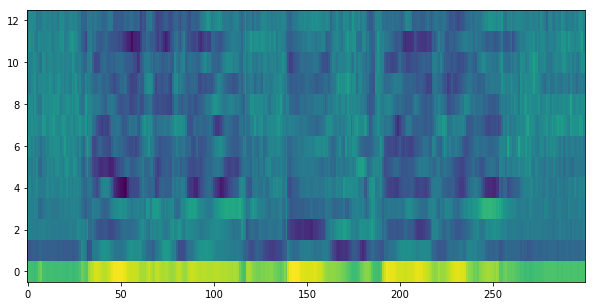

In [5]:
fig, ax = plt.subplots(figsize=(10,5), facecolor='white')
ax.imshow(trim_dict['lib-0001-fc-008-part'].T, origin='lower', aspect='auto')

## Plot ali.\*.gz

In [13]:
# retrieve ali.*.gz
result = subprocess.run([KALDI_HOME+'/src/bin/show-alignments', 
                        phones, final_mdl, 'ark:gunzip -c '+ali_gz+'|'], 
                        stdout=subprocess.PIPE, shell=False)
print(' '.join(result.args))
out = result.stdout.decode('utf-8').strip()
out = [o for o in out.split('\n') if o != '']

/home/kaldi/src/bin/show-alignments ./make_prep_files/align/phones.txt ./make_prep_files/align/final.mdl ark:gunzip -c ./make_prep_files/align/ali.1.gz|


In [10]:
ali_dict = {}
# get nframes from odd number indices
for i, t in enumerate(out[::2]):
    key = t.split('  ')[0].strip()
    frames = [tt.strip(']|[| ').split(' ') for tt in t.split('  ')[1].split('] [')]
    nframes = [len(f) for f in frames]
    ali_dict[key] = {'nframes': nframes}
# get phone labels from even number indices    
for i, t in enumerate(out[1::2]):
    key = t.split('  ')[0].strip()
    labs_raw = re.split(r'\s+', t.strip())[1:]
    labs = [re.sub('_.*','',b) for b in labs_raw] # removing context
    ali_dict[key].update({'labels':labs, 'labels_raw':labs_raw})
# e.g. ali_dict['lib-0001-fc-008-part']['labels']    

In [12]:
ali_dict.keys()

dict_keys(['lib-0001-fc-001', 'lib-0001-fc-002', 'lib-0001-fc-003', 'lib-0001-fc-004', 'lib-0001-fc-005', 'lib-0001-fc-006', 'lib-0001-fc-007', 'lib-0001-fc-008', 'lib-0001-fc-008-part', 'lib-0001-fc-009', 'lib-0001-fc-010'])

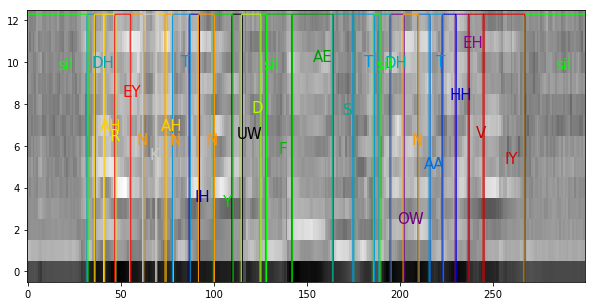

In [24]:
def plot_boxes(fid, ali_dict, trim_dict, which_lab=None):
    # draw boxes for all phone labels or a single phone
    # e.g., plot_boxes('lib-0001-fc-008-part', ali_dict, trim_dict)
    # e.g., plot_boxes('lib-0001-fc-008-part', ali_dict, trim_dict, which_lab='sil')
    mfcc = trim_dict[fid] # frame x dim
    nframes = ali_dict[fid]['nframes']
    frames = sum(nframes)
    labels = ali_dict[fid]['labels']
    if which_lab:
        uq = [which_lab]
        fig, ax = plt.subplots(figsize=(10,5), facecolor='white')
        ax.imshow(trim_dict[fid].T, origin='lower', aspect='auto', cmap='binary')
        ylim = ax.get_ylim()
        cm_list = ['red']
        
        for q, col in zip(uq, cm_list):
            x = 0
            for frm, lab in zip(nframes, labels):
                if q == lab:
                    ax.add_patch(patches.FancyBboxPatch((x, ylim[0]), frm, ylim[1], fill=False,
                                                        boxstyle=patches.BoxStyle("Round", pad=0.3),
                                                        edgecolor=col))
                    ax.text(x + frm/2, ylim[1]/2, lab, 
                            color=col, fontsize=15)
                    x += frm
                else:
                    x += frm
        
    else:
        uq = list(set(labels))
    
        fig, ax = plt.subplots(figsize=(10,5), facecolor='white')
        ax.imshow(trim_dict[fid].T, origin='lower', aspect='auto', cmap='binary')
        ylim = ax.get_ylim()
        cmap = cm.nipy_spectral
        cm_list = np.linspace(0, 255, len(uq))
        cm_list = np.floor(cm_list).astype(np.int)

        for q, col in zip(uq, cm_list):
            x = 0
            col_hex = matplotlib.colors.rgb2hex(cmap(col))
            pad = np.random.randn()*2
            for frm, lab in zip(nframes, labels):
                if q == lab:
                    ax.add_patch(patches.FancyBboxPatch((x, ylim[0]), frm, ylim[1], fill=False,
                                                        boxstyle=patches.BoxStyle("Round", pad=0.3),
                                                        edgecolor=col_hex))
                    ax.text(x + frm/2, ylim[1]/2+pad, lab, 
                            color=col_hex, fontsize=15)
                    x += frm
                else:
                    x += frm    
                
plot_boxes('lib-0001-fc-008-part', ali_dict, trim_dict, which_lab=None)    

In [155]:
IPython.display.Audio(wav)